# How To Get Couchbase Performance Metrics With Python

### Part 1: Collecting Couchbase metrics from the Couchbase API

### Introduction

Couchbase provides an administration console with graphs of performance metrics as well as a [REST](https://developer.couchbase.com/documentation/server/3.x/admin/REST/rest-bucket-stats.html) interface. The graphs are useful for quick analysis, but the console lacks the ability to view metrics graphed over each other and give no way of exporting the raw data.

This article shows how to retrieve metric data from the REST api and examples of how to plot the data for deeper analysis and visualization.  It includes a python class that can be imported and used to simplify the data extraction process.

### Quick Starter on getting Couchbase metrics 

The Clicker class abstracts the REST call to retrieve bucket data.  Use it as an example of how to extract bucket statistics from the Couchbase REST API or import it directly into your python code and use it.

### Getting Started

Install the modules using pip.  These will be used for data and visualization.

In [1]:
!pip -q install pandas numpy matplotlib

Review the Clicker class.  This will be used to pull the data from couchbase.  You will see how it's used as we work through the data.

In [2]:
# %load clicker.py
import requests
import numpy
import datetime
import time
import csv
import json
import logging

logging.basicConfig(format="%(asctime)s - %(thread)s - %(levelname)s - %(message)s")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

class Clicker:
    """ gets stuff from the couch """
    def __init__(self, event):
        if 'debug' in event and event['debug'] == True:
            self._set_logger(logging.DEBUG)
        self.event = event
        self.host = event['host']
        self.bucket = event['bucket']
        self.zoom = event['zoom']
        self.metrics = event['metrics']
        self.creds = event['creds']
        self.session = self.get_session()
        self.uri = self.geturi()
        logger.debug(event)

    def _set_logger(self, level=logging.INFO):
        logger.setLevel(level)

    def get_session(self):
        session = requests.Session()
        return session

    def geturi(self):
        url = "http://{host}:8091/pools/default/buckets/{bucket}/stats?zoom={zoom}".format(host=self.host,
                                                                                           bucket=self.bucket,
                                                                                           zoom=self.zoom)
        return url

    def getraw(self):
        raw_data = self.session.get("%s" % (self.uri), auth=(self.creds[0], self.creds[1])).json()
        return raw_data

    def getdata(self):
        data = self.getraw()
        return_data = []
        ts = data['op']['samples']['timestamp']
        for metric in self.metrics:
            if metric in data['op']['samples']:
                dataset = data['op']['samples'][metric]
                if 'mem' in metric or 'disk_size' in metric:
                    dataset[:] = [int(x / (1024 * 1024)) for x in metrics]
                return_data.append(dataset)
            else:
                return False
        return ts, return_data

## Imports

Now we begin building our python routine.  Import the modules.

In [ ]:
#import clicker
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

## Input

The clicker class takes a dictionary object as a parameter.  It will specify all the information needed to retrieve the metrics we want.  After running through this example, go back to this part and change these values to extract different metrics.  You will need to rerun the steps below to load the new data also.

In [4]:
event = {
    'host':'10.10.10.60',
    'bucket': 'NeonCache',
    'zoom': 'day',
    'metrics': ['cmd_set','cmd_get','cpu_utilization_rate'],
    'creds' : ['readonly', 'xxxxxxxxxxxx']
    }

## Get Data

Let's pull the data from couchbase.  Create a function called *get_metrics* that will instantiate a Clicker object and run *getdata*.  Remember, the event created above will tell Clicker what we want.

In [5]:
def get_metrics(event):
    c = Clicker(event)
    dt, metrics = c.getdata()
    return dt, metrics

raw_dt, metrics = get_metrics(event) 

## Transform Data

The data is returned in arrays.  *raw_dt* is an array of unix timestamps.  metrics is an array of arrays for each metric we requested.
The format of the dates are not ideal, so we need to manipulate them first.  See the *fix_dates* function and how we do that.  The new list for dates is called simply *dt*

In [6]:
def fix_dates(data):
    fixed=[]
    for dt in data:
        fixed.append( long(str(dt/1000)) ) 
    return mdates.epoch2num(fixed)

dt=fix_dates(raw_dt)

*fix_dates* alters the dates for plotting, but its still not something a human can read.  Below is a quick function to that can do that.  We don't need it for plotting, but we will output the data to a table to get a look at it in the next step.

In [7]:
def convert_dt(dt):    
    return(datetime.datetime.fromtimestamp(int(dt)/1000).strftime('%Y-%m-%d %H:%M:%S'))

map(convert_dt, raw_dt)[0:5]

['2018-08-01 06:33:00',
 '2018-08-01 06:34:00',
 '2018-08-01 06:35:00',
 '2018-08-01 06:36:00',
 '2018-08-01 06:37:00']

## Model the data

Use pandas to create a dataframe to view the data as a table.  This will allow us to inspect the data before graphing it.  Review this function, you can look deeper into [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) later if you want to know more.

We output the top 15 records.

In [8]:
str_dt = map(convert_dt, raw_dt)

def tabulate_data(top):
    df=pd.DataFrame(metrics, columns= str_dt)
    row_names = {}
    for idx, metric in enumerate(event['metrics']):
        row_names[idx] = metric
    df.rename(index=row_names, inplace=True)
    return df.transpose()[0:top]

tabulate_data(top=15)

,cmd_set,cmd_get,cpu_utilization_rate
2018-08-01 06:33:00,0.107143,13.222882,37.896570
2018-08-01 06:34:00,0.178571,12.799299,17.120648
2018-08-01 06:35:00,0.071429,12.817962,17.703125
2018-08-01 06:36:00,0.072782,12.825477,17.810358
2018-08-01 06:37:00,0.071429,12.984970,18.924409
2018-08-01 06:38:00,0.211903,13.390775,20.593682
2018-08-01 06:39:00,0.142857,13.518397,18.781261
2018-08-01 06:40:00,0.072825,13.068258,19.944295
2018-08-01 06:41:00,0.071429,13.160360,18.432110
2018-08-01 06:42:00,0.107143,12.827646,20.543661


## Visualization

Finally, we plot the data using matpyplot.  

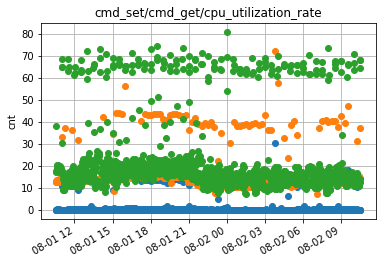

In [9]:
def plot(dt,data, fmt):
    for m in data:
        plt.plot_date(x=dt, y=m, fmt=fmt)
    plt.title('/'.join(event['metrics']))
    plt.ylabel('cnt')
    plt.grid(True)
    fig = plt.figure(1)
    fig.autofmt_xdate()
    plt.show()
 
plot(dt,metrics,fmt='o')